----------------------------------------------------------

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
import os
import copy
import requests
import io
import timm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(len(avail_pretrained_models))

1289


In [ ]:
from google.colab import files
files.upload()
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d abdulmananraja/real-life-violence-situations
! mkdir -p "/content/gdrive/MyDrive/Datasets/violence_data"
! unzip real-life-violence-situations.zip -d "/content/gdrive/MyDrive/Datasets/violence_data"

In [ ]:
data_dir = "/content/gdrive/MyDrive/Datasets/violence_data/new_violence/"

img_size = 224  # size for the transferred model

data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


image_datasets = datasets.ImageFolder(data_dir, data_transforms)

# Training the visual transformer with patch 16

In [ ]:
all_vit_models = timm.list_models('*vit*', pretrained=True)
all_vit_models

model = timm.create_model('vit_base_patch16_224', pretrained=True)
# Compute total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params
model.eval()

# Printing the dataset size

In [ ]:
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes, class_names)

11073 ['non_violence', 'violence']


# Getting the validation, train, and test sets of data and feeding them into loader

In [ ]:
val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_len, val_len = len(train_dataset), len(val_dataset)

In [ ]:
batch_size = 64
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False)

In [ ]:
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

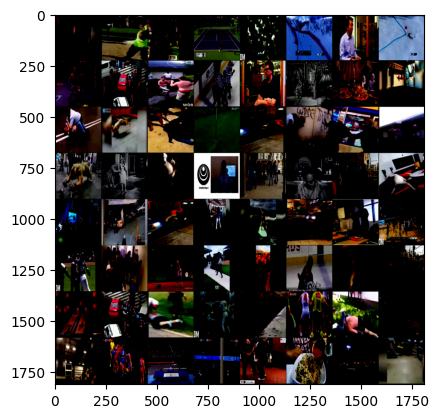

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # if use option1 dataloader
    # inp = inp.cpu().numpy().transpose((1, 2, 0))
    # if use option2 dataloader
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loader_train))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out)

## Evaluation of vioдence given model and input

In [ ]:
def eval_violence(model, loader_val):
  model.eval()

  preds = []
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in the model: {total_params}")

model.head = torch.nn.Linear(model.head.in_features, 2)
model.to(device)

In [ ]:
#Fine Tuning
for param in model.parameters():
    param.requires_grad = True

# Unfreeze the classifier layer (assuming 'model.head' is the classifier layer)
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [ ]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [ ]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

## Training phase

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
      #print(torch.max(logits, dim=1)[1])
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_violence(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=4.56e+01 train accu=89.76% validation accu=94.34% 
[Step 2] loss=4.68e+01 train accu=90.00% validation accu=96.51% 
[Step 3] loss=2.97e+01 train accu=97.73% validation accu=96.81% 
[Step 4] loss=2.76e+01 train accu=98.88% validation accu=48.19% 
[Step 5] loss=3.41e+01 train accu=96.38% validation accu=97.83% 
[Step 6] loss=2.64e+01 train accu=99.11% validation accu=83.92% 
[Step 7] loss=2.71e+01 train accu=98.77% validation accu=97.59% 
[Step 8] loss=2.52e+01 train accu=99.65% validation accu=95.06% 
[Step 9] loss=2.65e+01 train accu=99.08% validation accu=97.41% 
[Step 10] loss=2.50e+01 train accu=99.66% validation accu=97.95% 


In [ ]:
save_path = "/content/gdrive/MyDrive/Datasets/vit1.pth"
torch.save(model, save_path)

In [ ]:
import torch
import timm

# Define the path to your saved model file

model = torch.load('/content/gdrive/MyDrive/Datasets/vit1.pth')

model.to(torch.device('cuda'))

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accus_test = []
model.eval()
loss = []
precision = []
recall = []
f1 = []
losses = [[]]
for x, t in loader_test:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())

    loss = loss_fn(logits, t)
    loss.backward()
    losses.append(loss.item())


## Testing

In [ ]:
with torch.no_grad():
   accus_test.append(eval_violence(model, loader_test))




print(f'Test accuracy for Vit Base ={accus_test[-1]:.2%}')
print(f'Loss={losses[-1]}')

Test accuracy for Vit Base =98.49%
Loss=0.20400969684123993


In [ ]:
model.eval()
x, t = next(iter(loader_test))
x= x.to(device)
t = t.to(device)
x.size()

torch.Size([64, 3, 224, 224])

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0)
    return input_image

In [ ]:
def get_attention_maps(model, input_image):
    with torch.no_grad():
        outputs = model(input_image)
        attention_maps = outputs['attn']
        print(attention_maps)
    return attention_maps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_map(image_path, attention_map):
    image = Image.open(image_path).convert('RGB')
    attention_map = attention_map.mean(dim=1, keepdim=True)
    attention_map = torch.nn.functional.interpolate(attention_map, size=(224, 224), mode='bilinear', align_corners=False)
    attention_map = attention_map.squeeze(0).numpy()

    plt.imshow(np.array(image))
    plt.imshow(attention_map, alpha=0.5, cmap='viridis')
    plt.show()

## Visual Transformer with patch 32

In [ ]:

model = timm.create_model('vit_small_patch32_224.augreg_in21k_ft_in1k', pretrained=True)

# Compute total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params
model.eval()

In [ ]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in the model: {total_params}")

model.head = torch.nn.Linear(model.head.in_features, 2)
model.to(device)

In [ ]:
#Fine Tuning
for param in model.parameters():
    param.requires_grad = True

# Unfreeze the classifier layer (assuming 'model.head' is the classifier layer)
for param in model.head.parameters():
    param.requires_grad = True


In [ ]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [ ]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [ ]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

## Training

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
      #print(torch.max(logits, dim=1)[1])
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_violence(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=5.90e+01 train accu=81.96% validation accu=90.90% 
[Step 2] loss=3.44e+01 train accu=96.03% validation accu=97.29% 
[Step 3] loss=2.78e+01 train accu=99.34% validation accu=96.87% 
[Step 4] loss=2.62e+01 train accu=99.78% validation accu=98.13% 
[Step 5] loss=2.50e+01 train accu=99.92% validation accu=98.19% 
[Step 6] loss=2.46e+01 train accu=99.94% validation accu=98.31% 
[Step 7] loss=2.46e+01 train accu=99.94% validation accu=98.31% 
[Step 8] loss=2.45e+01 train accu=99.95% validation accu=98.31% 
[Step 9] loss=2.44e+01 train accu=99.96% validation accu=98.37% 
[Step 10] loss=2.44e+01 train accu=99.94% validation accu=98.25% 


In [ ]:
save_path = "/content/gdrive/MyDrive/Datasets/vit2.pth"
torch.save(model, save_path)

In [ ]:
import torch
import timm

# Define the path to your saved model file

model = torch.load('/content/gdrive/MyDrive/Datasets/vit2.pth')

model.to(torch.device('cuda'))

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

## Testing

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accus_test = []
model.eval()
loss = []
precision = []
recall = []
f1 = []
losses = [[]]
for x, t in loader_test:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())

    loss = loss_fn(logits, t)
    loss.backward()
    losses.append(loss.item())
with torch.no_grad():
   accus_test.append(eval_violence(model, loader_test))




print(f'Test accuracy for Vit Small ={accus_test[-1]:.2%}')
print(f'Loss={losses[-1]}')

Test accuracy for Vit Small =98.49%
Loss=0.2243044674396515


### ResNet

In [ ]:
#randomize parameters
model = timm.create_model('resnet50', pretrained=True)
# Compute total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params
model.eval()
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_classes = 2  # Use the number of classes from your custom dataset_
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [ ]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [ ]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

# Training

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
      #print(torch.max(logits, dim=1)[1])
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_violence(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=8.22e+01 train accu=60.54% validation accu=69.04% 
[Step 2] loss=6.73e+01 train accu=78.68% validation accu=83.13% 
[Step 3] loss=5.00e+01 train accu=86.75% validation accu=83.49% 
[Step 4] loss=4.39e+01 train accu=90.20% validation accu=84.04% 
[Step 5] loss=4.01e+01 train accu=92.62% validation accu=90.66% 
[Step 6] loss=3.80e+01 train accu=94.17% validation accu=84.34% 
[Step 7] loss=3.59e+01 train accu=95.27% validation accu=88.43% 
[Step 8] loss=3.47e+01 train accu=95.77% validation accu=93.67% 
[Step 9] loss=3.32e+01 train accu=96.83% validation accu=89.64% 
[Step 10] loss=3.32e+01 train accu=96.87% validation accu=91.08% 


In [ ]:
save_path = "/content/gdrive/MyDrive/Datasets/resnet.pth"
torch.save(model, save_path)

In [ ]:
import torch
import timm

# Define the path to your saved model file

model = torch.load('/content/gdrive/MyDrive/Datasets/resnet.pth')

model.to(torch.device('cuda'))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## Testing (accuracy and loss)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accus_test = []
model.eval()
loss = []
precision = []
recall = []
f1 = []
losses = [[]]
for x, t in loader_test:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())

    loss = loss_fn(logits, t)
    loss.backward()
    losses.append(loss.item())
with torch.no_grad():
   accus_test.append(eval_violence(model, loader_test))




print(f'Test accuracy for Resnet ={accus_test[-1]:.2%}')
print(f'Loss={losses[-1]}')

Test accuracy for Resnet =91.93%
Loss=0.3024821877479553


### DenseNet

In [ ]:
#randomize parameters
model = timm.create_model('densenet201', pretrained=True)
# Compute total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params
model.eval()
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_classes = 2  # Use the number of classes from your custom dataset_
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [ ]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [ ]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

## Testing

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
      #print(torch.max(logits, dim=1)[1])
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_violence(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=5.86e+01 train accu=80.86% validation accu=90.84% 
[Step 2] loss=3.88e+01 train accu=93.40% validation accu=96.69% 
[Step 3] loss=2.86e+01 train accu=99.06% validation accu=98.19% 
[Step 4] loss=2.65e+01 train accu=99.87% validation accu=98.01% 
[Step 5] loss=2.64e+01 train accu=99.85% validation accu=92.65% 
[Step 6] loss=2.65e+01 train accu=99.90% validation accu=97.89% 
[Step 7] loss=2.54e+01 train accu=99.90% validation accu=97.95% 
[Step 8] loss=2.54e+01 train accu=99.95% validation accu=98.01% 
[Step 9] loss=2.55e+01 train accu=99.92% validation accu=98.07% 
[Step 10] loss=2.53e+01 train accu=99.95% validation accu=97.05% 


## Testing (accuracy and loss)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accus_test = []
model.eval()
loss = []
precision = []
recall = []
f1 = []
for x, t in loader_test:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    # print(logits.mean())

    loss = loss_fn(logits, t)
    loss.backward()
    losses.append(loss.item())
with torch.no_grad():
   accus_test.append(eval_violence(model, loader_test))




print(f'Test accuracy for DenseNet201 ={accus_test[-1]:.2%}')
print(f'Loss={losses[-1]}')

Test accuracy for DenseNet201 =97.11%


In [ ]:
print(f'Loss={losses[-1]}')

Loss=0.2675406336784363


In [ ]:
save_path = "/content/gdrive/MyDrive/Datasets/dense201.pth"
torch.save(model, save_path)

In [ ]:
import numpy as np


model.eval()

features = []
labels = []

with torch.no_grad():
    for inputs, labels_batch in loader_test:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        outputs = model(inputs)  # Adjust based on your model architecture
        # Extract features from an intermediate convolutional layer

        features.append(model(inputs).cpu().numpy())
        labels.append(labels_batch.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

## T SNE

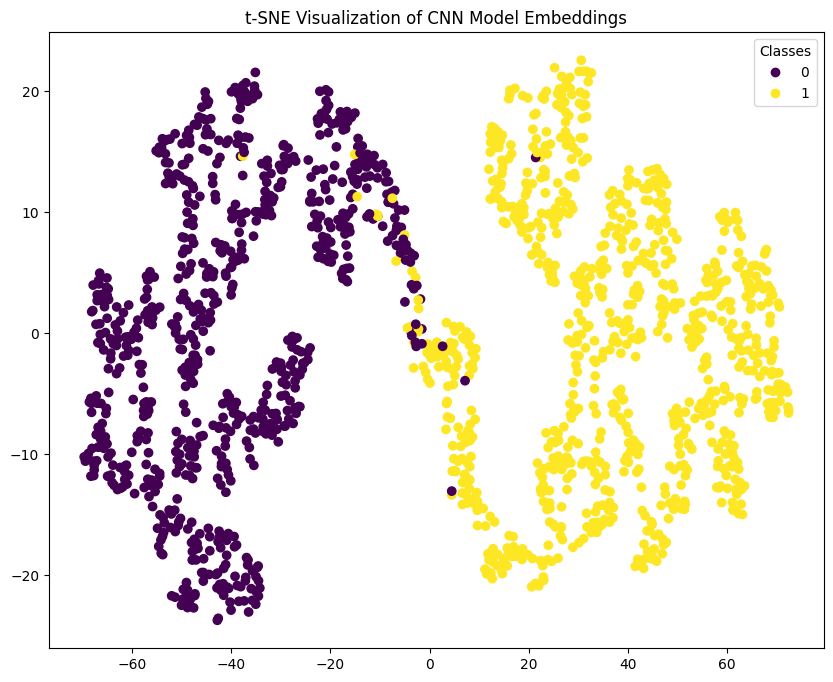

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'features' is a numpy array of shape (num_samples, feature_dim)
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE Visualization of CNN Model Embeddings')
plt.show()

GradCam

In [ ]:
import torch
import timm

# Define the path to your saved model file

model = torch.load('/content/gdrive/MyDrive/Datasets/dense201.pth')

model.to(torch.device('cuda'))

In [ ]:
from torch import nn
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # get the pretrained DenseNet201 network
        self.densenet = model

        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features

        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)

        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((-1, 1920))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)


# Visualizing predictions for: ViTs, Resnet and Densenet

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00


In [ ]:
import torch
import random
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import drive
import torchvision as tv
from torchvision import datasets, models, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = "/content/gdrive/MyDrive/Datasets/violence_data/new_violence/"

img_size = 224  # size for the transferred model

data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


image_datasets = datasets.ImageFolder(data_dir, data_transforms)

dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes, class_names)

val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_len, val_len = len(train_dataset), len(val_dataset)

batch_size = 64
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False)

loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

11073 ['non_violence', 'violence']


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.to(device)
    print('GPU')

GPU


Randomly selected samples for class non_violence:


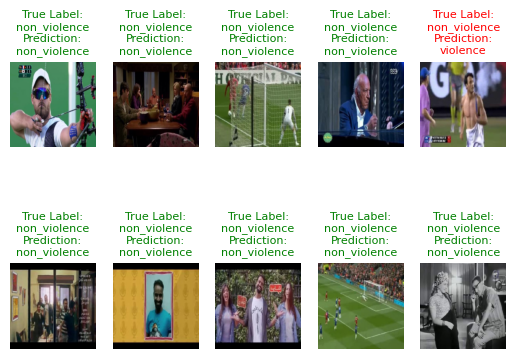

Randomly selected samples for class violence:


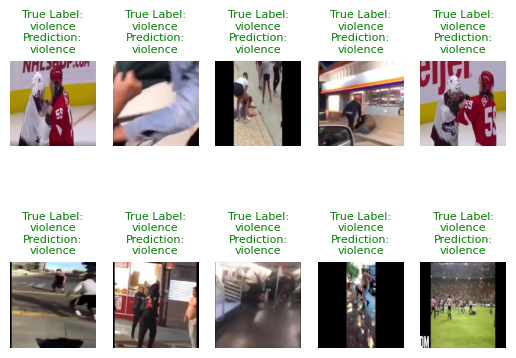

In [ ]:
import random
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt


data_dir = "/content/gdrive/MyDrive/Datasets/violence_data/new_violence/"

img_size = 224  # size for the transferred model

data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_datasets = datasets.ImageFolder(data_dir, data_transforms)
classes = image_datasets.classes  # Retrieve class names

# Load the trained model for testing
model = torch.load('/content/gdrive/MyDrive/Datasets/dense201.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


# Create a dictionary to keep track of class indices
class_indices = {classname: [] for classname in classes}

# Find indices of images for each class
for i, (image, label) in enumerate(test_dataset):
    class_indices[classes[label]].append(i)

# Create a dictionary to store 5 randomly selected samples per class
random_samples = {classname: [] for classname in classes}

# Select 5 random images from each class
for classname, indices in class_indices.items():
    random_indices = random.sample(indices, min(10, len(indices)))
    for i in random_indices:
        image, label = test_dataset[i]
        image = image.to(device)
        output = model(image.unsqueeze(0))  # Make a prediction for a single image
        _, prediction = torch.max(output, 1)
        random_samples[classname].append((image, label, prediction.item()))

# Visualize random samples with highlighting for misclassified predictions
for classname, samples in random_samples.items():
    print(f"Randomly selected samples for class {classname}:")
    for i, (image, label, prediction) in enumerate(samples):
        plt.subplot(2, 5, i + 1)
        image = image.cpu().numpy().transpose(1, 2, 0) / 2 + 0.5
        plt.imshow(image)

        # Check if prediction is correct, if not, highlight in red
        if label != prediction:
            title_color = 'red'
        else:
            title_color = 'green'

        plt.title(f"True Label:\n{classes[label]}\nPrediction:\n{classes[prediction]}", fontsize=8, color=title_color)
        plt.axis('off')
    plt.show()
